## Load Packages

In [1]:
import albumentations as A
import gc
import librosa
import matplotlib.pyplot as plt
import math
import multiprocessing
import numpy as np
import os
import pandas as pd
import pywt
import random
import time
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

from albumentations.pytorch import ToTensorV2
from glob import glob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import Dict, List

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')

Using 1 GPU(s)


In [2]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#   tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
class config:
    BATCH_SIZE = 64
    MODEL = "tf_efficientnet_b0"
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    VISUALIZE = False
    FREEZE = False
    
    
class paths:
    MODEL_WEIGHTS = "/kaggle/input/hms-multi-class-image-classification-train/tf_efficientnet_b0_epoch_3.pth"
    OUTPUT_DIR = "/kaggle/working/"
    TEST_CSV = "/kaggle/input/hms-harmful-brain-activity-classification/test.csv"
    TEST_EEGS= "/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/"
    TEST_SPECTROGRAMS = "/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/"
    
    TRAIN_CSV = "/kaggle/input/hms-harmful-brain-activity-classification/train.csv"
    
efficentnet_model_weights = [x for x in glob("/kaggle/input/hms-efficientnetb0-5-folds/*.pth")]
wavenet_model_weights = [x for x in glob("/kaggle/input/brain-eegs/WaveNet_Model/WaveNet_fold*.h5")]
efficentnetV2_model_weights = [x for x in glob("/kaggle/input/mixmodel-weights/pop_2_weight_oof/tf_efficientnet_b0_ns_fold*_best_version2_stage2.pth")]

efficentnetV2_model_weights

['/kaggle/input/mixmodel-weights/pop_2_weight_oof/tf_efficientnet_b0_ns_fold1_best_version2_stage2.pth',
 '/kaggle/input/mixmodel-weights/pop_2_weight_oof/tf_efficientnet_b0_ns_fold2_best_version2_stage2.pth',
 '/kaggle/input/mixmodel-weights/pop_2_weight_oof/tf_efficientnet_b0_ns_fold3_best_version2_stage2.pth',
 '/kaggle/input/mixmodel-weights/pop_2_weight_oof/tf_efficientnet_b0_ns_fold0_best_version2_stage2.pth',
 '/kaggle/input/mixmodel-weights/pop_2_weight_oof/tf_efficientnet_b0_ns_fold4_best_version2_stage2.pth']

In [4]:
test_df = pd.read_csv(paths.TEST_CSV)
print(f"Test dataframe shape is: {test_df.shape}")
test_df.head()

Test dataframe shape is: (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


## WaveNet Mode

### Load Data

In [5]:
FEATS = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
FEAT2IDX = {x:y for x,y in zip(FEATS,range(len(FEATS)))}
SAMPLES = 5_000

In [6]:
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

import scipy.signal

def eeg_from_parquet(parquet_path, display=False):
    
    eeg = pd.read_parquet(parquet_path, columns=FEATS)
    rows = len(eeg)
    offset = (rows-SAMPLES)//2
    eeg = eeg.iloc[offset:offset+SAMPLES]
    
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0
    
    # CONVERT TO NUMPY
    data = np.zeros((SAMPLES,len(FEATS)))
    for j,col in enumerate(FEATS):
        
        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0
        
        # Downsampling from 200 Hz to 100 Hz
        downsampled_x = scipy.signal.resample(x, SAMPLES)
        data[:, j] = downsampled_x
        
        if display: 
            if j!=0: offset += x.max()
            plt.plot(range(SAMPLES),x-offset,label=col)
            offset -= x.min()
            
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1]
        name = name.split('.')[0]
        plt.title(f'EEG {name}',size=16)
        plt.show()
        
    return data

Processing Test EEG parquets...



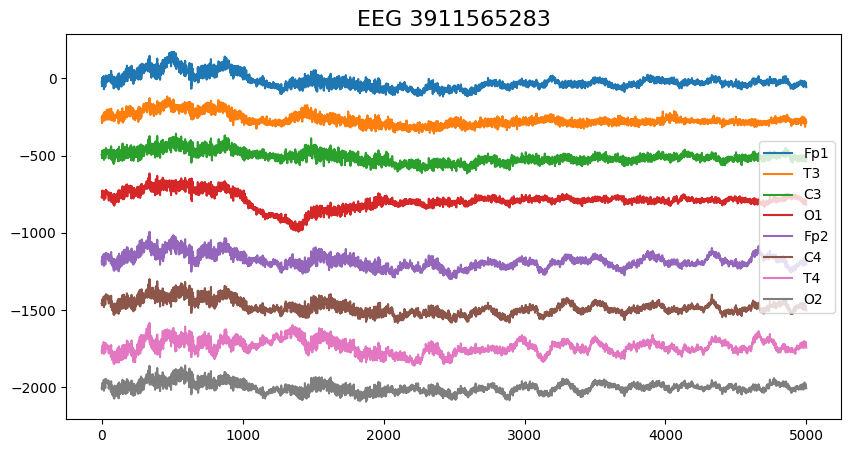

In [7]:
raw_eegs = {}
DISPLAY = 1
EEG_IDS2 = test_df.eeg_id.unique()
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'

print('Processing Test EEG parquets...'); print()
for i,eeg_id in enumerate(EEG_IDS2):
    # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
    data = eeg_from_parquet(f'{PATH2}{eeg_id}.parquet', i<DISPLAY)
    raw_eegs[eeg_id] = data

In [8]:
# class DataGenerator(tf.keras.utils.Sequence):
#     'Generates data for Keras'
#     def __init__(self, data, batch_size=32, shuffle=False, eegs=all_eegs, mode='train',
#                  downsample=5): 

#         self.data = data
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.eegs = eegs
#         self.mode = mode
#         self.downsample = downsample
#         self.on_epoch_end()
        
#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         ct = int( np.ceil( len(self.data) / self.batch_size ) )
#         return ct

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
#         X, y = self.__data_generation(indexes)
#         return X[:,::self.downsample,:], y

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange( len(self.data) )
#         if self.shuffle: np.random.shuffle(self.indexes)
                        
#     def __data_generation(self, indexes):
#         'Generates data containing batch_size samples' 
    
#         X = np.zeros((len(indexes),10_000,8),dtype='float32')
#         y = np.zeros((len(indexes),6),dtype='float32')
        
#         sample = np.zeros((10_000,X.shape[-1]))
#         for j,i in enumerate(indexes):
#             row = self.data.iloc[i]      
#             data = self.eegs[row.eeg_id]
            
#             # FEATURE ENGINEER
#             sample[:,0] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['T3']]
#             sample[:,1] = data[:,FEAT2IDX['T3']] - data[:,FEAT2IDX['O1']]
            
#             sample[:,2] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['C3']]
#             sample[:,3] = data[:,FEAT2IDX['C3']] - data[:,FEAT2IDX['O1']]
            
#             sample[:,4] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['C4']]
#             sample[:,5] = data[:,FEAT2IDX['C4']] - data[:,FEAT2IDX['O2']]
            
#             sample[:,6] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['T4']]
#             sample[:,7] = data[:,FEAT2IDX['T4']] - data[:,FEAT2IDX['O2']]
            
#             # STANDARDIZE
#             sample = np.clip(sample,-1024,1024)
#             sample = np.nan_to_num(sample, nan=0) / 32.0
            
#             # BUTTER LOW-PASS FILTER
#             sample = butter_lowpass_filter(sample)
            
#             X[j,] = sample
#             if self.mode!='test':
#                 y[j] = row[TARGETS]
            
#         return X,y

In [9]:
# test_gen = DataGenerator(test_df, shuffle=False, batch_size=64, eegs=all_eegs, mode='test')

### Model

In [10]:
# from tensorflow.keras.layers import Input, Dense, Multiply, Add, Conv1D, Concatenate

# def wave_block(x, filters, kernel_size, n):
#     dilation_rates = [2**i for i in range(n)]
#     x = Conv1D(filters = filters,
#                kernel_size = 1,
#                padding = 'same')(x)
#     res_x = x
#     for dilation_rate in dilation_rates:
#         tanh_out = Conv1D(filters = filters,
#                           kernel_size = kernel_size,
#                           padding = 'same', 
#                           activation = 'tanh', 
#                           dilation_rate = dilation_rate)(x)
#         sigm_out = Conv1D(filters = filters,
#                           kernel_size = kernel_size,
#                           padding = 'same',
#                           activation = 'sigmoid', 
#                           dilation_rate = dilation_rate)(x)
#         x = Multiply()([tanh_out, sigm_out])
#         x = Conv1D(filters = filters,
#                    kernel_size = 1,
#                    padding = 'same')(x)
#         res_x = Add()([res_x, x])
#     return res_x

# def build_model():
        
#     # INPUT 
#     inp = tf.keras.Input(shape=(2_000,8))
    
#     ############
#     # FEATURE EXTRACTION SUB MODEL
#     inp2 = tf.keras.Input(shape=(2_000,1))
#     x = wave_block(inp2, 8, 3, 12)
#     x = wave_block(x, 16, 3, 8)
#     x = wave_block(x, 32, 3, 4)
#     x = wave_block(x, 64, 3, 1)
#     model2 = tf.keras.Model(inputs=inp2, outputs=x)
#     ###########
    
#     # LEFT TEMPORAL CHAIN
#     x1 = model2(inp[:,:,0:1])
#     x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
#     x2 = model2(inp[:,:,1:2])
#     x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
#     z1 = tf.keras.layers.Average()([x1,x2])
    
#     # LEFT PARASAGITTAL CHAIN
#     x1 = model2(inp[:,:,2:3])
#     x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
#     x2 = model2(inp[:,:,3:4])
#     x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
#     z2 = tf.keras.layers.Average()([x1,x2])
    
#     # RIGHT PARASAGITTAL CHAIN
#     x1 = model2(inp[:,:,4:5])
#     x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
#     x2 = model2(inp[:,:,5:6])
#     x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
#     z3 = tf.keras.layers.Average()([x1,x2])
    
#     # RIGHT TEMPORAL CHAIN
#     x1 = model2(inp[:,:,6:7])
#     x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
#     x2 = model2(inp[:,:,7:8])
#     x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
#     z4 = tf.keras.layers.Average()([x1,x2])
    
#     # COMBINE CHAINS
#     y = tf.keras.layers.Concatenate()([z1,z2,z3,z4])
#     y = tf.keras.layers.Dense(64, activation='relu')(y)
#     y = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(y)
    
#     # COMPILE MODEL
#     model = tf.keras.Model(inputs=inp, outputs=y)
#     opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
#     loss = tf.keras.losses.KLDivergence()
#     model.compile(loss=loss, optimizer = opt)
    
#     return model

In [11]:
# model = build_model()

In [12]:
# from tensorflow.keras.models import Model

# def get_concatenated_features(model, layer):
#     # Extract features up to the concatenate_2 layer
#     feature_extraction_model = Model(inputs=model.input, outputs=model.get_layer(layer).output)
#     return feature_extraction_model

In [13]:
# import tensorflow.keras.backend as K, gc

# wavenet_features = []

# for i in range(5):
#     model = build_model()
#     model.load_weights(f'/kaggle/input/brain-eegs/WaveNet_Model/WaveNet_fold{i}.h5')
    
#     feature_extraction_model = get_concatenated_features(model, f'concatenate_{i+1}')
#     features = feature_extraction_model.predict(test_gen, verbose=1)
    
#     wavenet_features.append(features)
#     del model, feature_extraction_model, features
#     gc.collect()

In [14]:
# wavenet_features[0].shape

In [15]:
# def clear_gpu_memory():
#     torch.cuda.empty_cache()
#     gc.collect()

# # Call the function before proceeding with your PyTorch model
# clear_gpu_memory()

## EfficientNet Model

In [16]:
USE_WAVELET = None 

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

def spectrogram_from_eeg(parquet_path, display=False):
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
            
            
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0

    return img

In [17]:
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'

EEG_IDS2 = test_df.spectrogram_id.unique()
all_spectrograms = {}

for spectogram_id in tqdm(EEG_IDS2):
    aux = pd.read_parquet(f'{PATH2}{spectogram_id}.parquet')
    all_spectrograms[spectogram_id] = aux.iloc[:,1:].values
    del aux

100%|██████████| 1/1 [00:00<00:00, 22.24it/s]


In [18]:
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
EEG_IDS2 = test_df.eeg_id.unique()
all_eegs = {}
counter = 0

for eeg_id in tqdm(EEG_IDS2):
    eeg_spectrogram = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet', counter < 1)
    all_eegs[int(eeg_id)] = eeg_spectrogram
    counter += 1

100%|██████████| 1/1 [00:09<00:00,  9.59s/it]


In [19]:
# class CustomModel(nn.Module):
#     def __init__(self, config, num_classes: int = 6):
#         super(CustomModel, self).__init__()
#         self.USE_KAGGLE_SPECTROGRAMS = True
#         self.USE_EEG_SPECTROGRAMS = True
#         self.model = timm.create_model(
#             config.MODEL,
#             pretrained=False
#         )
#         self.features = nn.Sequential(*list(self.model.children())[:-2])
#         self.custom_layers = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Flatten(),
#             nn.Linear(self.model.num_features, num_classes)
#         )

#     def __reshape_input(self, x):
#         """
#         Reshapes input (128, 256, 8) -> (512, 512, 3) monotone image.
#         """ 
#         # === Get spectrograms ===
#         spectrograms = [x[:, :, :, i:i+1] for i in range(4)]
#         spectrograms = torch.cat(spectrograms, dim=1)
        
#         # === Get EEG spectrograms ===
#         eegs = [x[:, :, :, i:i+1] for i in range(4,8)]
#         eegs = torch.cat(eegs, dim=1)
        
#         # === Reshape (512,512,3) ===
#         if self.USE_KAGGLE_SPECTROGRAMS & self.USE_EEG_SPECTROGRAMS:
#             x = torch.cat([spectrograms, eegs], dim=2)
#         elif self.USE_EEG_SPECTROGRAMS:
#             x = eegs
#         else:
#             x = spectrograms
            
#         x = torch.cat([x,x,x], dim=3)
#         x = x.permute(0, 3, 1, 2)
#         return x
    
#     def forward(self, x):
#         x = self.__reshape_input(x)
#         x = self.features(x)
#         x = self.custom_layers(x)
#         return x

In [20]:
# class CustomDataset(Dataset):
#     def __init__(
#         self, df: pd.DataFrame, config,
#         augment: bool = False, mode: str = 'train',
#         specs: Dict[int, np.ndarray] = all_spectrograms,
#         eeg_specs: Dict[int, np.ndarray] = all_eegs
#     ): 
#         self.df = df
#         self.config = config
#         self.batch_size = self.config.BATCH_SIZE
#         self.augment = augment
#         self.mode = mode
#         self.spectrograms = all_spectrograms
#         self.eeg_spectrograms = all_eegs
        
#     def __len__(self):
#         """
#         Denotes the number of batches per epoch.
#         """
#         return len(self.df)
        
#     def __getitem__(self, index):
#         """
#         Generate one batch of data.
#         """
#         X, y = self.__data_generation(index)
#         if self.augment:
#             X = self.__transform(X)
#         return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
                        
#     def __data_generation(self, index):
#         """
#         Generates data containing batch_size samples.
#         """
#         X = np.zeros((128, 256, 8), dtype='float32')
#         y = np.zeros(6, dtype='float32')
#         img = np.ones((128,256), dtype='float32')
#         row = self.df.iloc[index]
#         if self.mode=='test': 
#             r = 0
#         else: 
#             r = int((row['min'] + row['max']) // 4)
            
#         for region in range(4):
#             img = self.spectrograms[row.spectrogram_id][r:r+300, region*100:(region+1)*100].T
            
#             # Log transform spectrogram
#             img = np.clip(img, np.exp(-4), np.exp(8))
#             img = np.log(img)

#             # Standarize per image
#             ep = 1e-6
#             mu = np.nanmean(img.flatten())
#             std = np.nanstd(img.flatten())
#             img = (img-mu)/(std+ep)
#             img = np.nan_to_num(img, nan=0.0)
#             X[14:-14, :, region] = img[:, 22:-22] / 2.0
#             img = self.eeg_spectrograms[row.eeg_id]
#             X[:, :, 4:] = img
                
#             if self.mode != 'test':
#                 y = row[label_cols].values.astype(np.float32)
            
#         return X, y
    
#     def __transform(self, img):
#         transforms = A.Compose([
#             A.HorizontalFlip(p=0.5),
#         ])
#         return transforms(image=img)['image']

In [21]:
class ResNet_1D_Block(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsampling):
        super(ResNet_1D_Block, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        self.relu = nn.ReLU(inplace=False)
        self.dropout = nn.Dropout(p=0.1, inplace=False)
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.downsampling = downsampling

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)

        out = self.maxpool(out)
        identity = self.downsampling(x)

        out += identity
        return out
    

class EEGMegaNet(nn.Module):

    def __init__(self, backbone_2d,in_channels_2d, kernels, pretrained=False, in_channels=20, fixed_kernel_size=17, num_classes=6):
        super(EEGMegaNet, self).__init__()
        
        self.kernels = kernels
        self.planes = 24
        self.parallel_conv = nn.ModuleList()
        self.in_channels = in_channels

        self.backbone_2d = timm.create_model(
            backbone_2d,
            pretrained=pretrained,
            drop_rate = 0.1,
            drop_path_rate = 0.1
        
        )
        
        self.features_2d = nn.Sequential(*list(self.backbone_2d.children())[:-2] + [nn.AdaptiveAvgPool2d(1),nn.Flatten()])
        
        # nn.Sequential(
            # nn.AdaptiveAvgPool2d(1),

        for i, kernel_size in enumerate(list(self.kernels)):
            sep_conv = nn.Conv1d(in_channels=in_channels, out_channels=self.planes, kernel_size=(kernel_size),
                               stride=1, padding=0, bias=False,)
            self.parallel_conv.append(sep_conv)

        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        self.relu = nn.ReLU(inplace=False)
        self.conv1 = nn.Conv1d(in_channels=self.planes, out_channels=self.planes, kernel_size=fixed_kernel_size,
                               stride=2, padding=2, bias=False)
        self.block = self._make_resnet_layer(kernel_size=fixed_kernel_size, stride=1, padding=fixed_kernel_size//2)
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=4, stride=4, padding=2)
        self.rnn = nn.GRU(input_size=self.in_channels, hidden_size=128, num_layers=1, bidirectional=True)
        
        self.fc1 = nn.Linear(in_features=1280, out_features=128)
        self.fc2 = nn.Linear(in_features=496, out_features=128)
        self.fc = nn.Linear(in_features=256, out_features=num_classes)

        self.fc1d = nn.Linear(in_features=128, out_features=num_classes)
        self.fc2d = nn.Linear(in_features=128, out_features=num_classes)
        
        
        self.rnn1 = nn.GRU(input_size=156, hidden_size=156, num_layers=1, bidirectional=True)

    def _make_resnet_layer(self, kernel_size, stride, blocks=8, padding=0):
        layers = []
        downsample = None
        base_width = self.planes

        for i in range(blocks):
            downsampling = nn.Sequential(
                    nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
                )
            layers.append(ResNet_1D_Block(in_channels=self.planes, out_channels=self.planes, kernel_size=kernel_size,
                                       stride=stride, padding=padding, downsampling=downsampling))

        return nn.Sequential(*layers)

    def _reshape_input(self, spec):
        """
        Reshapes input (128, 256, 8) -> (512, 512, 3) monotone image.
        """ 
        # === Get spectograms ===
        spectograms = [spec[:, :, :, i:i+1] for i in range(4)]
        spectograms = torch.cat(spectograms, dim=1)
        
        # === Get EEG spectograms ===
        eegs = [spec[:, :, :, i:i+1] for i in range(4,8)]
        eegs = torch.cat(eegs, dim=1)
        
        # === Reshape (512,512,3) ===
        spec = spectograms
            
        spec = torch.cat([spec,spec,spec], dim=3)
        spec = spec.permute(0, 3, 1, 2)
        return spec

    def forward(self, x, spec):
        
        spec = self._reshape_input(spec)
        spec = self.features_2d(spec)
        
        # print(spec.shape) #2, 1280, 16, 8
        out_sep = []

        for i in range(len(self.kernels)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)

        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv1(out)  

        out = self.block(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.avgpool(out)  


        
        out = out.reshape(out.shape[0], -1)  

        rnn_out, _ = self.rnn(x.permute(0,2, 1))
        new_rnn_h = rnn_out[:, -1, :]  

        new_out = torch.cat([out, new_rnn_h], dim=1)
        new_out = self.fc2(new_out)  
        out1d = self.fc1d(new_out)
        
        spec = self.fc1(spec)  
        out2d = self.fc2d(spec)
        
        result = torch.cat([new_out, spec], dim=1)  
        result = self.fc(result)
        
        
        return result #, new_out, spec, out1d, out2d

In [22]:
from scipy.signal import butter, lfilter

def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    # bins = np.linspace(-1, 1, classes)
    # quantized = np.digitize(mu_x, bins) - 1
    return mu_x#quantized

def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

class EEGDataset(torch.utils.data.Dataset):
    def __init__(
        self, df: pd.DataFrame,
        augment: bool = False, mode: str = 'train',
        specs: Dict[int, np.ndarray] = all_spectrograms,
        eeg_specs: Dict[int, np.ndarray] = all_eegs,
        eegs: Dict[int, np.ndarray] = raw_eegs
    ): 
        self.df = df
        self.augment = augment
        self.mode = mode
        self.spectograms = specs
        self.eeg_spectograms = eeg_specs
        self.eegs = eegs
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        # Processing EEG signal data
        eeg_data = self.eegs[row.eeg_id]
        sample = np.zeros((eeg_data.shape[0], 8))  # Assuming eeg_data.shape[1] == 8 for 8 channels
        FEAT2IDX = {'Fp1': 0, 'T3': 1, 'C3': 2, 'O1': 3, 'Fp2': 4, 'C4': 5, 'T4': 6, 'O2': 7}
        
        # Compute differences
        for i, (start, end) in enumerate([('Fp1', 'T3'), ('T3', 'O1'), ('Fp1', 'C3'), ('C3', 'O1'), 
                                          ('Fp2', 'C4'), ('C4', 'O2'), ('Fp2', 'T4'), ('T4', 'O2')]):
            sample[:, i] = eeg_data[:, FEAT2IDX[start]] - eeg_data[:, FEAT2IDX[end]]
        
        sample = self.process_sample(sample)
        
        samples = torch.from_numpy(sample).float()
        samples = samples.permute(1, 0)
        
        # Processing spectrogram data
        spec = self.__spec_data_generation(row)
        if self.augment:
            spec = self.__transform_2d(spec) 
        
        if self.mode != 'test':
            label = row[TARGETS]  # Assuming 'TARGETS' is defined somewhere as the label column name
            label = torch.tensor(label).float()  
            return samples, spec, label
        else:
            return samples, spec
    
    def process_sample(self, sample):
        # Normalize the sample data
        sample = (sample - np.mean(sample, axis=0)) / np.std(sample, axis=0)
        sample = np.clip(sample, -1024, 1024)
        sample = np.nan_to_num(sample, nan=0)
        sample = butter_lowpass_filter(sample)
        sample = quantize_data(sample, 1)
        return sample

    def __spec_data_generation(self, row):
        """
        Generates data containing batch_size samples. This method directly
        uses class attributes for spectrograms and EEG spectrograms.
        """
        X = np.zeros((128, 256, 8), dtype='float32')        
        if self.mode != 'test':
            # Assuming your DataFrame has a column that combines min and max values for slicing
            r = int(row['spectrogram_label_offset_seconds'] // 2)
        else:
            r = 0  # Adjust as necessary for test mode
        
        for region in range(4):
            img = self.spectograms[row.spectrogram_id][r:r+300, region*100:(region+1)*100].T
            
            # Log transform spectogram
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)
            
            ep = 1e-6
            mu = np.nanmean(img.flatten())
            std = np.nanstd(img.flatten())
            img = (img-mu)/(std+ep)
            img = np.nan_to_num(img, nan=0.0)
            X[14:-14, :, region] = img[:, 22:-22] / 2.0
            img = self.eeg_spectograms[row.eeg_id]
            X[:, :, 4:] = img
                 
        return X

    def __transform_2d(self, img):
        params1 = {
                    "num_masks_x": 1,    
                    "mask_x_length": (0, 20), # This line changed from fixed  to a range
                    "fill_value": (0, 1, 2, 3, 4, 5, 6, 7),
                    }
        params2 = {    
                    "num_masks_y": 1,    
                    "mask_y_length": (0, 20),
                    "fill_value": (0, 1, 2, 3, 4, 5, 6, 7),    
                    }
        params3 = {    
                    "num_masks_x": (2, 4),
                    "num_masks_y": 5,    
                    "mask_y_length": 8,
                    "mask_x_length": (10, 20),
                    "fill_value": (0, 1, 2, 3, 4, 5, 6, 7),  
                    }
        
        transforms = A.Compose([
            A.XYMasking(**params1, p=0.3),
            A.XYMasking(**params2, p=0.3),
            A.XYMasking(**params3, p=0.3),
        ])
        return transforms(image=img)['image']

In [23]:
# test_dataset = CustomDataset(test_df, config, mode="test")
# test_loader = DataLoader(
#     test_dataset,
#     batch_size=config.BATCH_SIZE,
#     shuffle=False,
#     num_workers=config.NUM_WORKERS, 
#     pin_memory=True, drop_last=False
# )

# X, y = test_dataset[0]
# print(f"X shape: {X.shape}")
# print(f"y shape: {y.shape}")

In [24]:
test_dataset = EEGDataset(test_df, augment=False, mode="test")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

samples, spec = test_dataset[0]

print(f"Samples shape: {samples.shape}")
print(f"Spec shape: {spec.shape}")

del test_dataset, samples, spec
_ = gc.collect()

Samples shape: torch.Size([8, 5000])
Spec shape: (128, 256, 8)


In [25]:
def load_weights(model, weights_path):
    checkpoint = torch.load(weights_path, map_location=torch.device(device))
    model.load_state_dict(checkpoint["model"])
    model.to(device)
    return model

In [26]:
def inference_function(test_loader, model, device):
    model.eval() # set model in evaluation mode
    softmax = nn.Softmax(dim=1)
    prediction_dict = {}
    preds = []
    with tqdm(test_loader, unit="test_batch", desc='Inference') as tqdm_test_loader:
        for step, (X, specs) in enumerate(tqdm_test_loader):
            X = X.to(device)
            specs = specs.to(device)
            batch_size = X.size(0)
            with torch.no_grad():
                y_preds = model(X, specs) # forward propagation pass
            y_preds = softmax(y_preds)
            preds.append(y_preds.to('cpu').numpy()) # save predictions
                
    prediction_dict["predictions"] = np.concatenate(preds) # np.array() of shape (fold_size, target_cols)
    return prediction_dict

In [27]:
# predictions = []

# for model_weight in efficentnetV2_model_weights:
#     model = CustomModel(config)
#     model = load_weights(model, model_weight)
    
#     prediction_dict = inference_function(test_loader, model, device)
#     predictions.append(prediction_dict["predictions"])
#     torch.cuda.empty_cache()
#     gc.collect()
    
# predictions = np.array(predictions)
# predictions = np.mean(predictions, axis=0)

In [28]:
predictions = []

for model_weight in efficentnetV2_model_weights:
    model = EEGMegaNet(backbone_2d=config.MODEL,
                   in_channels_2d=8,
                   kernels=[3,5,7,9],pretrained=False,
                   in_channels=8,
                   fixed_kernel_size=5, num_classes=6)
    model = load_weights(model, model_weight)
    
    prediction_dict = inference_function(test_loader, model, device)
    predictions.append(prediction_dict["predictions"])
    torch.cuda.empty_cache()
    gc.collect()
    
predictions = np.array(predictions)
predictions = np.mean(predictions, axis=0)

Inference: 100%|██████████| 1/1 [00:00<00:00, 23.93test_batch/s]


In [29]:
# def extract_features(model, dataloader):
#     features = []
#     model.eval()
#     with torch.no_grad():
#         for inputs, _ in tqdm(dataloader, desc="Extracting features", leave=False):
#             # Forward pass through the model to extract features
#             inputs=inputs.to(device)
            
#             outputs = model(inputs)
#             features.append(outputs['custom_layers.1'])
            
#     return torch.cat(features, dim=0)

In [30]:
# efficientnet_features = []

# for i in range(5):
#     custom_model = CustomModel(config)
#     custom_model = load_weights(custom_model, f"/kaggle/input/hms-efficientnetb0-5-folds/tf_efficientnet_b0_fold_{i}_best.pth")

#     feature_extractor = create_feature_extractor(
#         custom_model,
#         train_return_nodes=['custom_layers.1'],
#         eval_return_nodes=['custom_layers.1'],
#         tracer_kwargs={'autowrap_functions': [timm.layers.padding.pad_same]}
#     ).to(device)
    
#     features = extract_features(feature_extractor, test_loader)
    
#     efficientnet_features.append(features)

In [31]:
# efficientnet_features[0].shape

In [32]:
# efficientnetV2_features = []

# for i in range(5):
#     custom_model = CustomModel(config)
#     custom_model = load_weights(custom_model, 
#                                 f"/kaggle/input/hms-efficientnetb0-weights/pop_2_weight_oof/tf_efficientnet_b0_ns_fold{i}_best_version2_stage2.pth")

#     feature_extractor = create_feature_extractor(
#         custom_model,
#         train_return_nodes=['custom_layers.1'],
#         eval_return_nodes=['custom_layers.1'],
#         tracer_kwargs={'autowrap_functions': [timm.layers.padding.pad_same]}
#     ).to(device)
    
#     features = extract_features(feature_extractor, test_loader)
    
#     efficientnetV2_features.append(features)

In [33]:
# efficientnetV2_features[0].shape

## Ensemble Model

In [34]:
# wavenet_features_tensors = [torch.from_numpy(arr).to(device) for arr in wavenet_features]
# efficientnet_features_tensors = [tensor.to(device) for tensor in efficientnet_features]
# efficientnet_featuresV2_tensors = [tensor.to(device) for tensor in efficientnetV2_features]

# concatenated_features = torch.cat(efficientnet_featuresV2_tensors + wavenet_features_tensors + efficientnet_features_tensors, dim=1)

In [35]:
# class EnsembleModel(nn.Module):
#     def __init__(self, input_size, num_classes):
#         super(EnsembleModel, self).__init__()
#         self.fc1 = nn.Linear(input_size, 32)
#         self.bn1 = nn.BatchNorm1d(32)
#         self.dropout = nn.Dropout(0.5) 
#         self.fc2 = nn.Linear(32, num_classes)

#     def forward(self, x):
#         x = F.relu(self.bn1(self.fc1(x)))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

In [36]:
# model_path = '/kaggle/input/hms-ensemble-features/best_ensemble_model.pth'
# num_of_feautres = concatenated_features.shape[1]
# num_of_classes = 6

# model = EnsembleModel(num_of_feautres, num_of_classes)
# model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
# model.to(device)
# model.eval()

# predictions = model(concatenated_features)
# predictions = F.softmax(predictions, dim=1).detach().cpu().numpy()

In [37]:
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
sub = pd.DataFrame({'eeg_id': test_df.eeg_id.values})
sub[TARGETS] = predictions
sub.to_csv('submission.csv',index=False)
print(f'Submissionn shape: {sub.shape}')
sub.head()

Submissionn shape: (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.032133,0.133113,0.031662,0.153289,0.131787,0.518017
